In [1]:
import h5py as h
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import sys, os, time
import optuna

In [2]:
ds = h.File('catalog.h5')
print(ds)

<HDF5 file "catalog.h5" (mode r)>


## ARCHITECTURE

In [4]:
# N hidden layer code, similar structure to above but generalized
def dynamic_model2(input_size, output_size, n_layers, hidden, dr):

    # define the tuple containing the different layers
    layers = []

    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = hidden[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dr[i]))
        in_features = out_features

    # get the last layer
    layers.append(nn.Linear(out_features, output_size))

    # return the model
    return nn.Sequential(*layers)

#model = dynamic_model2(numFeatures, outSize, numHL, [h1, h2], [dr1, dr1])

In [5]:
from random import shuffle
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import sys, os, time, h5py
from pathlib import Path

In [6]:
def normalize_data(data, labels):
    ######################
    # normalize input
    ## the id's correspond to the id's of the feature array you made using vstack in read_data()
    data[:,0]  = (data[:,0] - np.mean(data[:,0]))/np.std(data[:,0]) # Z Scores
    data[:,1]  = (data[:,1] - np.mean(data[:,1]))/np.std(data[:,1])
    data[:,2]  = (data[:,2] - np.mean(data[:,2]))/np.std(data[:,2])
    data[:,3]  = (data[:,3] - np.mean(data[:,3]))/np.std(data[:,3])
    data[:,4]  = (data[:,4] - np.mean(data[:,4]))/np.std(data[:,4])

    ######################
    # normalize labels
    print ("labels", labels)

    # # array = np.log10(labels) # Since labels are large log them
    # print("labels array", array)
    # labels = array
    
    return data, labels

In [7]:
# read data and get training, validation or testing sets
# fin ---------> file with the data
# seed --------> random seed used to split among different datasets
# mode --------> 'train', 'valid', 'test' or 'all'
# normalize ---> whether to normalize the data or not
def read_data(fin, seed, mode, normalize): #fin for h5
    File = 'catalog.h5'
    f     = h5py.File(fin, 'r')
    masses = []
    fgases = []
    SFRs = []
    Mstars = []
    redshifts = []
    fescs = []
    groups = []
    min_dist = []
    t_lookback = []
    
    t_lookback_RP = np.array(np.load('t_lookback_RP.npy', allow_pickle = True))
    t_lookback_all = []
    for list_i in t_lookback_RP:
        for elem in list_i:
            t_lookback_all.append(elem)
        
    min_dist_RP = np.array(np.load('min_dist_RP.npy', allow_pickle = True))
    min_dist_all = []
    for listi in min_dist_RP:
        for elem in listi:
            min_dist_all.append(elem)
    
    for halo in f.keys():
        fesc_list = list(f[halo]['fesc']) 
        for index, fesc in enumerate(fesc_list):
            if fesc <= 0.01:
                group = 0
            elif 0.01 < fesc <= 0.10:
                group = 1
            elif 0.10 < fesc <= 0.25:
                group = 2
            else:
                group = 3
                
            if fesc >= 1e-5:
                masses.append(f[halo]['mass'][index])
                fgases.append(f[halo]['fgas'][index])
                SFRs.append(f[halo]['SFR'][index])
                Mstars.append(f[halo]['Mstar'][index])
                redshifts.append(f[halo]['redshift'][index])
                fescs.append(fesc)
                groups.append(group)
                t_lookback.append(t_lookback_all[index])
                min_dist.append(min_dist_all[index])
    # min_SFR = np.min(SFRs[SFRs != 0])
    minsfr = 100
    for each in SFRs:
        if each < minsfr and each != 0.:
            minsfr = each
    new_SFRs = []
    for SFR in SFRs:
        if SFR == 0.0:
            new_SFRs.append(minsfr*0.9)
        else:
            new_SFRs.append(SFR)        
    # normalize data - EDIT
    ## anything not on order 10^0 - 10^1 should be logged
    masses = np.log10(masses)
    SFRs = np.log10(new_SFRs)
    Mstars = np.log10(Mstars)
    fgases = np.log10(fgases)
    min_dist = np.log10(min_dist)
    t_lookback = np.log10(t_lookback)
    
    # get data, labels and number of elements
    data = np.vstack([SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback]).T # THESE ARE YOUR CHOSEN INPUT VARIABLES
    
    labels = np.array(groups, dtype = 'int')
    print("labels.shape", labels.shape)
    # labels = fluxes.reshape((fluxes.shape[0], fluxSize))
    elements = data.shape[0]
    
    # normalize data
    if normalize:  data, labels = normalize_data(data, labels)

    # get the size and offset depending on the type of dataset
    if   mode=='train':   size, offset = int(elements*0.70), int(elements*0.00)
    elif mode=='valid':   size, offset = int(elements*0.15), int(elements*0.70)
    elif mode=='test':    size, offset = int(elements*0.15), int(elements*0.85)
    elif mode=='all':     size, offset = int(elements*1.00), int(elements*0.00)
    else:                 raise Exception('Wrong name!')

    # randomly shuffle the cubes. Instead of 0 1 2 3...999 have a 
    # random permutation. E.g. 5 9 0 29...342
    np.random.seed(seed)
    indexes = np.arange(elements) 
    np.random.shuffle(indexes)
    indexes = indexes[offset:offset+size] #select indexes of mode

    return data[indexes], labels[indexes]



In [8]:
class make_dataset():

    def __init__(self, mode, seed, fin):

        # get data
        inp, out = read_data(fin, seed, mode, normalize=True)

        # get the corresponding bottlenecks and parameters
        self.size   = inp.shape[0]
        self.input  = torch.tensor(inp, dtype=torch.float32)
        self.output = torch.tensor(out, dtype= torch.long)
        
        print ("size of input and output", np.shape(self.input), np.shape(self.output))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [9]:
def create_dataset(mode, seed, fin, batch_size, shuffle):
    data_set = make_dataset(mode, seed, fin)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return dataset_loader

In [118]:
fin = 'catalog.h5'
dataname = 'RP'      # Nickname for data
seed = 20                # remember this to reproduce split
numFeatures = 7         # number of input properties
outSize = 4          # size of wavelength array
featurelist = 'SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback'

# OPTUNA HYPERPARMETERS
numHL = 1           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_1 = 100        # nodes in second hidden layer
h2_1 = 241
h3_1 = 259
h4_1 = 10
dr1_1 = 0.47455646387688233
dr2_1 = 0.2751854259494696
dr3_1 = 0.6564052005260577
dr4_1 = 0.44116917438303693
lr_1 = 0.001872910879768054
wd_1 = 4.238852508107672e-07
batch_size = 50
epochs = 100

In [119]:
# name of output files


name   = "Normal_dynamicmodel2"
device = torch.device('cpu')
# define loss function
criterion = nn.CrossEntropyLoss()  # MSE or Cross Entropy

# get train, validation, and test sets
print('preparing dataset...')
train_loader = create_dataset('train', seed, fin, batch_size, True)
valid_loader = create_dataset('valid', seed, fin, batch_size, False)
test_loader  = create_dataset('test',  seed, fin, batch_size, False)

preparing dataset...
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


In [120]:
model = dynamic_model2(numFeatures, outSize, numHL, [h1_1], [dr1_1])

In [122]:
fout   = 'testagain9.txt'
fmodel = 'testagain9.pt'
#casts parameters/buffers to specified gpu
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_1, betas=(0.5, 0.999), 
                              weight_decay=wd_1)

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):
    correct = 0
    total_ct = 0
    # do training
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model(x)
        #y = nn.Softmax(y)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
            
            m = nn.Softmax(dim = 1)
            y_NN = m(y_NN)
            for idx, value in enumerate(y_NN):
                if value.tolist().index(max(value)) == y[idx]:
                    correct += 1
                total_ct += 1
    accuracy = correct/total_ct
    test_loss /= points
    
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = test_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print(f'Accuracy:{accuracy}')
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 1204
000 1.024e+00 1.026e+00 (saving)
001 1.039e+00 1.027e+00
002 1.035e+00 1.028e+00
003 1.040e+00 1.027e+00
004 1.028e+00 1.036e+00
005 1.029e+00 1.027e+00
006 1.041e+00 1.026e+00 (saving)
007 1.042e+00 1.029e+00
008 1.031e+00 1.031e+00
009 1.035e+00 1.027e+00
010 1.026e+00 1.024e+00 (saving)
011 1.030e+00 1.021e+00 (saving)
012 1.027e+00 1.034e+00
013 1.018e+00 1.029e+00
014 1.036e+00 1.030e+00
015 1.039e+00 1.031e+00
016 1.026e+00 1.034e+00
017 1.014e+00 1.023e+00
018 1.026e+00 1.018e+00 (saving)
019 1.028e+00 1.032e+00
020 1.027e+00 1.025e+00
021 1.021e+00 1.020e+00
022 1.035e+00 1.032e+00
023 1.040e+00 1.024e+00
024 1.029e+00 1.029e+00
025 1.023e+00 1.027e+00
026 1.033e+00 1.028e+00
027 1.033e+00 1.021e+00
028 1.036e+00 1.021e+00
029 1.036e+00 1.023e+00
030 1.036e+00 1.023e+00
031 1.024e+00 1.023e+00
032 1.022e+00 1.022e+00
033 1.022e+00 1.029e+00
034 1.024e+00 1.025e+00
035 1.034e+00 1.031e+00
036 1.022e+00 1.019e+00
037 1.018e+00 1.024e

In [123]:
fout   = 'validagain9.txt'
fmodel = 'testagain9.pt'
#casts parameters/buffers to specified gpu
model.load_state_dict(torch.load(fmodel))
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr_1,
                             weight_decay=wd_1)	

start = time.time()
min_valid_loss = 1000
valid_loss, points = 0.0, 0
valid_losses = []
for epoch in range(epochs):
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            valid_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    valid_loss /= points

    # save model if it is better
    if valid_loss<min_valid_loss:
    #     torch.save(model.state_dict(), fmodel)
         min_valid_loss = valid_loss
         print('%03d %.3e (saving)'%(epoch, valid_loss))
    else:
         print('%03d %.3e'%(epoch, valid_loss))

    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e \n'%(epoch, valid_loss))
    f.close()
    valid_losses.append(valid_loss)
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 1204
000 1.024e+00 (saving)
001 5.136e-01 (saving)
002 3.419e-01 (saving)
003 2.563e-01 (saving)
004 2.050e-01 (saving)
005 1.708e-01 (saving)
006 1.464e-01 (saving)
007 1.281e-01 (saving)
008 1.138e-01 (saving)
009 1.024e-01 (saving)
010 9.313e-02 (saving)
011 8.536e-02 (saving)
012 7.879e-02 (saving)
013 7.316e-02 (saving)
014 6.829e-02 (saving)
015 6.402e-02 (saving)
016 6.025e-02 (saving)
017 5.690e-02 (saving)
018 5.391e-02 (saving)
019 5.121e-02 (saving)
020 4.877e-02 (saving)
021 4.656e-02 (saving)
022 4.453e-02 (saving)
023 4.268e-02 (saving)
024 4.097e-02 (saving)
025 3.939e-02 (saving)
026 3.793e-02 (saving)
027 3.658e-02 (saving)
028 3.532e-02 (saving)
029 3.414e-02 (saving)
030 3.304e-02 (saving)
031 3.201e-02 (saving)
032 3.104e-02 (saving)
033 3.012e-02 (saving)
034 2.926e-02 (saving)
035 2.845e-02 (saving)
036 2.768e-02 (saving)
037 2.695e-02 (saving)
038 2.626e-02 (saving)
039 2.560e-02 (saving)
040 2.498e-02 (saving)
041 2.438e

In [111]:
print(valid_losses)

[1.0354595761746168, 0.5193476936750813, 0.3456941792391171, 0.25913496762118476, 0.2072538745896866, 0.17268454075545162, 0.14799988790921106, 0.12949025947804166, 0.11509602591505398, 0.10358192512556012, 0.09416211542642129, 0.08631281939877704, 0.07967148490271063, 0.07397918211178128, 0.06904605074124774, 0.06472970906769895, 0.06092128567737961, 0.057536108621797706, 0.05450733560600315, 0.051781495579919276, 0.04931530444515734, 0.04707334938640945, 0.04502637740832389, 0.04315001181683408, 0.04142377679846177, 0.03983034713373508, 0.03835496466701517, 0.03698497983711433, 0.03570948807712441, 0.03451903894416193, 0.03340540155391346, 0.032361374001702276, 0.03138062743843552, 0.03045757766574594, 0.029587278745852066, 0.028765334345019378, 0.027987823455255273, 0.027251237845339855, 0.026552429135714962, 0.025888563812891646, 0.025257084827720294, 0.024655678680111988, 0.02408224709698819, 0.02353488257265443, 0.0230118471707257, 0.022511554091239682, 0.02203255159108834, 0.021

In [133]:
losses = np.loadtxt('testagain7.txt', delimiter = ' ')
train_losses = losses[:,1]
test_losses = losses[:,2]

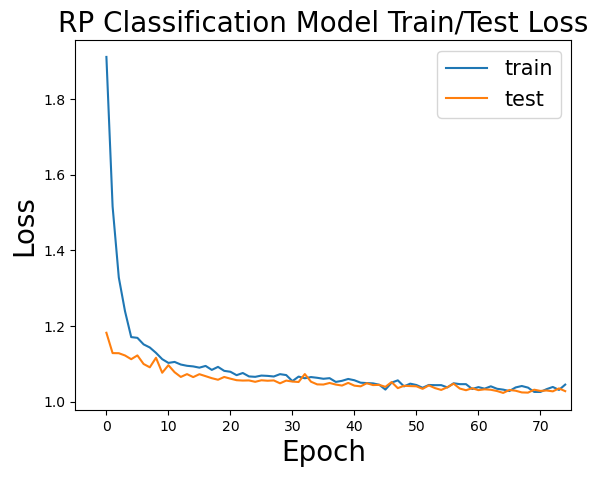

In [161]:
plt.plot(train_losses[0:75], label = 'train')
plt.plot(test_losses[0:75], label = 'test')
plt.legend(fontsize = 15)
plt.title("RP Classification Model Train/Test Loss", fontsize = 20)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.xlim(-5,75)



plt.savefig("RP Train_Test.png")

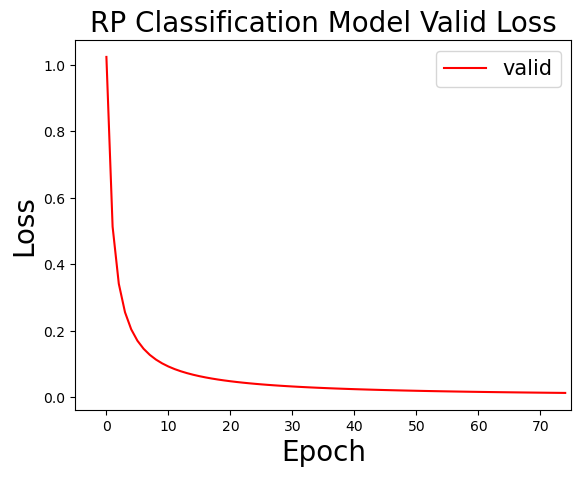

In [160]:
plt.plot(valid_losses[0:75], color = 'r', label = 'valid')
plt.legend(fontsize=15)
plt.title("RP Classification Model Valid Loss", fontsize = 20)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.xlim(-5,75)
plt.savefig("RP Valid.png")